In [79]:
import numpy as np
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import pickle
from sklearn.metrics import accuracy_score
from scipy.stats import sem
from sklearn.metrics import roc_curve, auc
import cv2
import matplotlib.patches as patches
%matplotlib inline
import pickle
from shutil import copyfile

# Input

In [80]:
# Distinct Pateints = 108, 7 patients have come repeatedly
# 67 NORMAL cases, hence, num XMLs = 410 - 67 = 343
net = "Retinanet" #YOLO or FRCNN or Retinanet
#outputfilename = "det_mal.txt"
# outputfilename = "mal_format_inbreast.txt"
outputfilename = "output_retinanet_INbreast.txt"
num_imgs = 410
data_img_path = "/home/anvit/Desktop/Data/INbreast/equalized_PNG_394_resized_ambiremoved/"
#outputfilename = "output_yolo_394.txt"

In [81]:
# Make dictionary of the form: {patient_id: {L: [MLO, CC], R: [MLO, CC]}, ..}
diction = {}
for file in os.listdir("/home/anvit/Desktop/Data/INbreast/Original_Inbreast/AllDICOMs/"):
    arr = file.split("_")
    if(arr[1] not in diction):
        diction[arr[1]] = {}
        diction[arr[1]][arr[3]] = [arr[0]]

    else:
        if(arr[3] not in diction[arr[1]]):
            diction[arr[1]][arr[3]] = [arr[0]]
        else:
            diction[arr[1]][arr[3]].append(arr[0])
print(len(diction))

modified_diction = {}
for elem in diction:
    try:
        if(len(diction[elem]['L'])==2):
            modified_diction[diction[elem]['L'][0]] = diction[elem]['L'][1]
    except:
        continue
        
for elem in diction:        
    try:
        if(len(diction[elem]['R'])==2):
            modified_diction[diction[elem]['R'][0]] = diction[elem]['R'][1]
    except:
        continue

108


In [82]:
# Count number of NORMAL cases
count = 0
file = open("/home/anvit/Desktop/Data/INbreast/Original_Inbreast/INbreast.csv")
lines = file.readlines()
for line in lines:
    arr = line.split(",")
    if(arr[7] == '1\n'):
        count += 1 
print(count)
print(410-count) # Num with lesions

67
343


In [83]:
# Obtain array of BENIGN cases
benign = []
malignant = []
normal = []
file = open("/home/anvit/Desktop/Data/INbreast/Original_Inbreast/INbreast.csv")
lines = file.readlines()
lines = lines[1:]
for line in lines:
    arr = line.split(",")
    if(arr[7] == '2\n' or arr[7] == '3\n'):
        benign.append(arr[5])
    elif(arr[7] != '1\n'):
        malignant.append(arr[5])
    elif(arr[7] == '1\n'):
        normal.append(arr[5])
        
print(len(benign))
print(343-len(benign)) # Num malignant
print(len(malignant))
print(len(normal))

243
100
100
67


/home/anvit/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/anvit/Desktop/Data/INbreast/Original_Inbreast/INbreast.csv' mode='r' encoding='UTF-8'>
  """


In [84]:
# Of the 100 malignant, 10 removed for relabelling, 1 corrupted
# These 89 are resized, non birads objects (benign objects) are removed
# Also 4a is removed since its very similar to 3 and 3 is considered benign
# With 4a removed, only 74 images are left, thereform num 4a = 15

In [85]:
# GT
mal_dict = {}

#for xml in malignant:
for xml in os.listdir("/home/anvit/Desktop/Data/INbreast/XML_VOC_malignant_BIRADS_resized/"):
    tree = ET.parse("/home/anvit/Desktop/Data/INbreast/XML_VOC_malignant_BIRADS_resized/"+xml)
    root = tree.getroot()
    if(len(root.findall('object'))>0): #4a removed
        mal_dict[xml[:-4]] = []
    for obj in root.findall('object'):
        bbox = obj[4]
        xmin = bbox[0].text
        ymin = bbox[1].text
        xmax = bbox[2].text
        ymax = bbox[3].text
        
        temparr = [xmin, ymin, xmax, ymax, 0]
        mal_dict[xml[:-4]].append(temparr)

print(len(mal_dict))
print(len(malignant))

75
100


In [86]:
# GT Authors
mal_dict_authors = {}

fil = open("/home/anvit/Desktop/Data/INbreast/Scripts/resizedgtauthors.txt", 'r')
lines = fil.readlines()

for line in lines:
    arr = line.split(",")
    if(arr[0] not in mal_dict_authors):
        mal_dict_authors[arr[0]] = [[float(arr[1]), float(arr[3]), float(arr[2]), float(arr[4])]]
    else:
        mal_dict_authors[arr[0]].append([float(arr[1]), float(arr[3]), float(arr[2]), float(arr[4])])

print(len(mal_dict_authors))
print(len(malignant))

84
100


/home/anvit/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/anvit/Desktop/Data/INbreast/Scripts/resizedgtauthors.txt' mode='r' encoding='UTF-8'>
  after removing the cwd from sys.path.


In [87]:
# Find files in malignant and not in mal_dict ie - 10 + 1 + 15 = 26
remmal = []
for f in malignant:
    if f not in mal_dict:
        remmal.append(f)
#print(remmal)
#print(len(remmal))

# Find those 8 files (16) image ambiguous ones:
ambi = []
for g in malignant:
    if g not in mal_dict_authors:
        ambi.append(g)
print(len(ambi))

# Find intersection of mal_dict_authors and malignant = mal_dict_authors
for h in mal_dict_authors:
    if h not in malignant:
        print("CRY")

# Identify those 16 ambiguous files
for file in ambi:
    print(file)
    
#Modified malignant: length 84 (not 100)
malignant = []
for j in mal_dict_authors:
    malignant.append(j)
print(len(malignant))

16
50997461
50997515
24055464
24055502
50998059
50998113
26933801
26933859
22614522
22614568
22613918
22613970
22670978
22671003
50996352
50996406
84


/home/anvit/.local/lib/python3.5/site-packages/ipykernel_launcher.py:22: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/anvit/Desktop/Data/INbreast/Original_Inbreast/INbreast.csv' mode='r' encoding='UTF-8'>


In [88]:
# Find files from remmal in mal_dict_authors: - 26 such cases, they have included 4a also in malignant
# They have excluded 8 ambiguous cases - ie 8x2 = 16 images, therefore have 100 - 16 = 84
w = 1
for v in remmal:
    if v in mal_dict_authors:
        w += 1
print(w)

18


In [89]:
# Assuming predictions for each malignant image in the form x_min, x_max, y_min, y_max for all lesions in a different row
# Image_name x_min, y_min, x_max, y_max malignant_confidence
# Assuming predictions sorted image wise

def getdicts(filename):
    if net == "YOLO":
        yolov3pred = open("/home/anvit/Desktop/Scripts/YOLO_output_files/"+filename,'r')
    elif net == "FRCNN":
        yolov3pred = open("/home/anvit/Desktop/Scripts/FasterRCNN_output_files/"+filename,'r')
    elif net == "Retinanet":
        yolov3pred = open("/home/anvit/Desktop/RetinaNet/pytorch-retinanet/output_files/"+filename, 'r')

    predictions = yolov3pred.readlines()
    #print(len(predictions))

    pred_dict = {}
    conf_dict = {}
    for row in predictions:
        row = row.rstrip()
        det = row.split(",")
        if (net == "Retinanet" and det[6] == "0") or (net == "YOLO" and det[7] == "BENIGN"):
            continue
        if(det[0][:-4] not in pred_dict):
            pred_dict[det[0][:-4]] = [[float(det[1]), float(det[2]), float(det[3]), float(det[4])]]
            conf_dict[det[0][:-4]] = det[5]

        else:
            pred_dict[det[0][:-4]].append([float(det[1]), float(det[2]), float(det[3]), float(det[4])])
            conf_dict[det[0][:-4]] = max(float(det[5]), float(conf_dict[det[0][:-4]]))
    
    yolov3pred.close()
    
    # Confidence = average confidence of all views
    for l in conf_dict:
        try:
            otherview = modified_diction[l]
            avg = (conf_dict[l] + conf_dict[otherview])/2
            conf_dict[l] = avg
            conf_dict[otherview] = avg
        except:
            continue
    
    return pred_dict, conf_dict

In [90]:
pred_dict, conf_dict = getdicts(outputfilename)

In [91]:
# Find malignant images with no predictions - 18 such cases for 343, 18 such cases for 410
keep = 0
for i in mal_dict_authors:
    if i not in pred_dict:
        #print(i)
        keep += 1
print(keep)

# There are 8 images in mal_dict not in mal_dict_authors (must be the 8 ambiguous ones)
# Length mal_dict = 74
# Length mal_dict_authors = 84
# Length malignant = 100

n=1
for i in mal_dict_authors:
    if i not in mal_dict:
        n+=1
#print(n)

0


# CLASSIFICATION

In [92]:
# METHOD 3 - Check all (0.73), low thresh of 0.001 - 0.82
# CLASSIFICATION GT LABEL:
imgdir = os.listdir("/home/anvit/Desktop/Data/INbreast/equalized_PNG_394_resized_ambiremoved/")
imgdir.sort()
gtlabel = []

for file in imgdir:
    if(file[:-4] in malignant):
        gtlabel.append(1)
    elif(file[:-4] in benign):
        gtlabel.append(0.0)
    elif(file[:-4] in normal):
        gtlabel.append(0)
        

predconf = []
normalasnormal = 0
for im in imgdir:
    try:
        if(float(conf_dict[im[:-4]]) < 0.001):
            predconf.append(0)
        else:
            predconf.append(float(conf_dict[im[:-4]]))

#         if(im[:-4] in normal):
#             print(float(conf_dict[im[:-4]]))

    except:
#         if(im[:-4] in normal):
#             normalasnormal += 1
        predconf.append(0)

#print(gtlabel)
#print(predconf)
# print(normalasnormal)

## ROC

0.9462749615975422


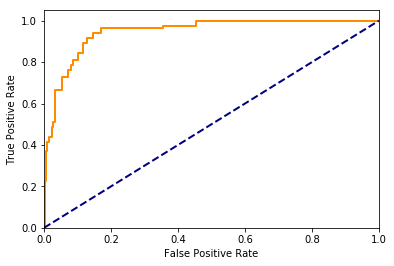

In [93]:
def plot_roc(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
print(roc_auc_score(gtlabel, predconf))
#pickle.dump({'gt': gtlabel, 'pred': predconf}, open('/home/anvit/Desktop/retinanet_roc_new.pk', "wb"))
fpr, tpr, threshold = roc_curve(gtlabel, predconf)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [94]:
# CLASSIFICATION - IMAGE LEVEL
sens = []
spec = []
accu = []
ones = []
for thresh in [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    print("THRESHOLD:",thresh)
    tp = 0
    fp = 0
    fn = 0
    tn = 0
#    for key in conf_dict: # BUT WHAT ABOUT THOSE THAT ARE NOT PREDICTED
#         if float(conf_dict[key]) >= thresh and (key in mal_dict):
#             tp += 1
#         elif float(conf_dict[key]) >= thresh and (key not in mal_dict):
#             fp += 1
#         elif float(conf_dict[key]) < thresh and (key in mal_dict):
#             fn += 1
#         elif float(conf_dict[key]) < thresh and (key not in mal_dict):
#             tn += 1

    for key in os.listdir("/home/anvit/Desktop/Data/INbreast/equalized_PNG_394_resized_ambiremoved/"):
        key = key[:-4]
        try:
            if float(conf_dict[key]) >= thresh and (key in mal_dict_authors):
                tp += 1
            elif float(conf_dict[key]) >= thresh and (key not in mal_dict_authors):
                fp += 1
            elif float(conf_dict[key]) < thresh and (key in mal_dict_authors):
                fn += 1
            elif float(conf_dict[key]) < thresh and (key not in mal_dict_authors):
                tn += 1
        except:
            # Not predicted
            if key in mal_dict_authors:
                fn += 1 # Penalty for missing
            continue
    
#     print("ACCURACY = ", tp/len(malignant))
    print(tp,tn,fp,fn)
#     acc = (tp + tn)/len(conf_dict)
    sen = tp/(tp + fn)
    spe = tn/(tn + fp)
#     print("ACCURACY =", acc)
    print("SENSITIVITY =", sen)
    print("SPECIFICITY =", spe)
#     accu.append(acc)
#     sens.append(sen)
#     spec.append(spe)
#     ones.append(1)

# tpr = np.array(sens)
# fpr = np.array(ones) - np.array(spec)
# print("ROC CURVE")
# plt.plot(fpr, tpr)
# plt.show()
# #pickle.dump({'x': fpr, 'y': tpr}, open('/home/anvit/Desktop/frcnn_roc.pk', "wb"))

THRESHOLD: 0.0
84 0 298 0
SENSITIVITY = 1.0
SPECIFICITY = 0.0
THRESHOLD: 0.05
84 0 298 0
SENSITIVITY = 1.0
SPECIFICITY = 0.0
THRESHOLD: 0.1
84 35 263 0
SENSITIVITY = 1.0
SPECIFICITY = 0.1174496644295302
THRESHOLD: 0.15
84 93 205 0
SENSITIVITY = 1.0
SPECIFICITY = 0.31208053691275167
THRESHOLD: 0.2
84 155 143 0
SENSITIVITY = 1.0
SPECIFICITY = 0.5201342281879194
THRESHOLD: 0.25
81 188 110 3
SENSITIVITY = 0.9642857142857143
SPECIFICITY = 0.6308724832214765
THRESHOLD: 0.3
81 233 65 3
SENSITIVITY = 0.9642857142857143
SPECIFICITY = 0.7818791946308725
THRESHOLD: 0.35
71 262 36 13
SENSITIVITY = 0.8452380952380952
SPECIFICITY = 0.8791946308724832
THRESHOLD: 0.4
68 270 28 16
SENSITIVITY = 0.8095238095238095
SPECIFICITY = 0.9060402684563759
THRESHOLD: 0.45
61 281 17 23
SENSITIVITY = 0.7261904761904762
SPECIFICITY = 0.9429530201342282
THRESHOLD: 0.5
56 284 14 28
SENSITIVITY = 0.6666666666666666
SPECIFICITY = 0.9530201342281879
THRESHOLD: 0.55
49 288 10 35
SENSITIVITY = 0.5833333333333334
SPECIFICIT

# LOCALIZATION

In [95]:
# GENERATE MULTIPLE THRESHOLD FILES:

def generatefile(thresh):
    if net == "YOLO":
        read = open("./YOLO_output_files/" + outputfilename, 'r')
        outputname = "./YOLO_output_files/output_yolo_" + str(thresh) + ".txt"
    elif net == "FRCNN":
        read = open("./FasterRCNN_output_files/" + outputfilename, 'r')
        outputname = "./FasterRCNN_output_files/output_frcnn_" + str(thresh) + ".txt"
    elif net == "Retinanet":
        read = open("/home/anvit/Desktop/RetinaNet/pytorch-retinanet/output_files/" + outputfilename, 'r')
        outputname = "/home/anvit/Desktop/RetinaNet/pytorch-retinanet/output_files/output_retinanet_" + str(thresh) + ".txt"
    
    write = open(outputname, 'w')
    
    lines = read.readlines()
    for line in lines:
        arr = line.split(",")
        if( float(arr[5]) >= thresh):
        #if(float(arr[5]) >= thresh):
            write.write(line)
    read.close()
    write.close()

In [96]:
generatefile(0.001)
generatefile(0.003)
generatefile(0.005)
generatefile(0.007)
generatefile(0.009)
generatefile(0.01)
generatefile(0.02)
generatefile(0.03)
generatefile(0.04)
generatefile(0.05)
generatefile(0.06)
generatefile(0.07)
generatefile(0.08)
generatefile(0.09)
generatefile(0.1)
generatefile(0.11)
generatefile(0.12)
generatefile(0.13)
generatefile(0.14)
generatefile(0.15)
generatefile(0.16)
generatefile(0.17)
generatefile(0.18)
generatefile(0.19)
generatefile(0.2)
generatefile(0.21)
generatefile(0.22)
generatefile(0.23)
generatefile(0.24)
generatefile(0.25)
generatefile(0.26)
generatefile(0.27)
generatefile(0.28)
generatefile(0.29)
generatefile(0.3)
generatefile(0.31)
generatefile(0.32)
generatefile(0.33)
generatefile(0.34)
generatefile(0.35)
generatefile(0.36)
generatefile(0.37)
generatefile(0.38)
generatefile(0.39)
generatefile(0.4)
generatefile(0.41)
generatefile(0.42)
generatefile(0.43)
generatefile(0.44)
generatefile(0.45)
generatefile(0.46)
generatefile(0.47)
generatefile(0.48)
generatefile(0.49)
generatefile(0.5)
generatefile(0.51)
generatefile(0.52)
generatefile(0.53)
generatefile(0.54)
generatefile(0.55)
generatefile(0.56)
generatefile(0.57)
generatefile(0.58)
generatefile(0.59)
generatefile(0.6)
generatefile(0.61)
generatefile(0.62)
generatefile(0.63)
generatefile(0.64)
generatefile(0.65)
generatefile(0.66)
generatefile(0.67)
generatefile(0.68)
generatefile(0.69)
generatefile(0.7)
generatefile(0.71)
generatefile(0.72)
generatefile(0.73)
generatefile(0.74)
generatefile(0.75)
generatefile(0.76)
generatefile(0.77)
generatefile(0.78)
generatefile(0.79)
generatefile(0.8)
generatefile(0.81)
generatefile(0.82)
generatefile(0.83)
generatefile(0.84)
generatefile(0.85)
generatefile(0.86)
generatefile(0.87)
generatefile(0.88)
generatefile(0.89)
generatefile(0.9)
generatefile(0.91)
generatefile(0.92)
generatefile(0.93)
generatefile(0.94)
generatefile(0.95)
generatefile(0.96)
generatefile(0.97)
generatefile(0.98)
generatefile(0.99)

In [97]:
# NUM OF FALSE POSTIVE BOXES generated for each test image
# TO ADD - Benign score, with inc threshold, even number of benign pred should reduce
pd = []
tpforsens = []
fnforsens = []
val = num_imgs
t = [0.001, 0.003, 0.005, 0.007, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

for thresh in t:
    print("THRESHOLD,", thresh)
    if net == "YOLO":
        pred_dict, conf_dict = getdicts("output_yolo_" + str(thresh) + ".txt")
    elif net == "FRCNN":
        pred_dict, conf_dict = getdicts("output_frcnn_" + str(thresh) + ".txt")
    elif net == "Retinanet":
        pred_dict, conf_dict = getdicts("output_retinanet_" + str(thresh) + ".txt")

    
    fpcount = 0
    tpcount = 0
    # pi = predicted image
    for pi in pred_dict:
        preds = pred_dict[pi]
        conf = conf_dict[pi]
        try:
            gt = mal_dict_authors[pi]
        except:
            fpcount += len(preds)
            continue
        
        orig = len(preds)
        possiblefp = len(preds)
        
        for pred_lesion in preds:
            xmid = (float(pred_lesion[0]) + float(pred_lesion[2]))/2
            ymid = (float(pred_lesion[1]) + float(pred_lesion[3]))/2
            for gt_lesion in gt:
                if ( (xmid >= float(gt_lesion[0]) and xmid <= float(gt_lesion[2])) and (ymid >= float(gt_lesion[1]) and ymid <= float(gt_lesion[3])) ): #and float(conf) >= thresh): # and gt_lesion[4] == 0):
                    tpcount += 1
                    possiblefp -= 1
                    #gt_lesion[4] = 1
        fpcount += max(possiblefp,0)
        #print("Number of FPs for image", str(pi), " = ", max(0,possiblefp), "out of", str(orig))
    
    #print("Avg number of FP per image =", fpcount/len(mal_dict_authors))
    print("Avg number of FP per image =", fpcount/val)
    print("Number of TP =", tpcount)
    pd.append(fpcount/val)
    tpforsens.append(tpcount)
    
    fncount = 0
    
    for gti in  mal_dict_authors:
        gt = mal_dict_authors[gti]
        orig = len(gt)
        possiblefn = len(gt)
        try:
            preds = pred_dict[gti]
            for gt_lesion in gt:
                for pred_lesion in preds:
                    xmid = (float(pred_lesion[0]) + float(pred_lesion[2]))/2
                    ymid = (float(pred_lesion[1]) + float(pred_lesion[3]))/2
                    #print(xmid, ymid)
                    if(xmid >= float(gt_lesion[0]) and xmid <= float(gt_lesion[2])) and (ymid >= float(gt_lesion[1]) and ymid <= float(gt_lesion[3])):
                        possiblefn -= 1
                        gt_lesion[4] = 1
                        break

            fncount += possiblefn
            #print("Number of FNs for image", str(gti), "=", possiblefn, "out of", str(orig))
        except:
            fncount += possiblefn
            #print("Number of FNs for image", str(gti), "=", possiblefn, "out of", str(orig))
    
    print("Number of FN =", fncount)
    fnforsens.append(fncount)
    print("Sensitivity =", tpcount/(tpcount + fncount))

THRESHOLD, 0.001
Avg number of FP per image = 21.353658536585368
Number of TP = 1255
Number of FN = 8
Sensitivity = 0.9936658749010293
THRESHOLD, 0.003
Avg number of FP per image = 21.353658536585368
Number of TP = 1255
Number of FN = 8
Sensitivity = 0.9936658749010293
THRESHOLD, 0.005
Avg number of FP per image = 21.353658536585368
Number of TP = 1255
Number of FN = 8
Sensitivity = 0.9936658749010293
THRESHOLD, 0.007
Avg number of FP per image = 21.353658536585368
Number of TP = 1255
Number of FN = 8
Sensitivity = 0.9936658749010293
THRESHOLD, 0.009
Avg number of FP per image = 21.353658536585368
Number of TP = 1255
Number of FN = 8
Sensitivity = 0.9936658749010293
THRESHOLD, 0.01
Avg number of FP per image = 21.353658536585368
Number of TP = 1255
Number of FN = 8
Sensitivity = 0.9936658749010293
THRESHOLD, 0.02
Avg number of FP per image = 21.353658536585368
Number of TP = 1255
Number of FN = 8
Sensitivity = 0.9936658749010293
THRESHOLD, 0.03
Avg number of FP per image = 21.353658536

0.31 0.28780487804878047 0.9044585987261147
0.31 0.28780487804878047 0.9044585987261147


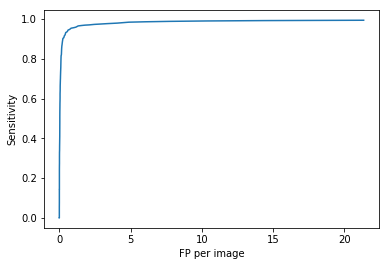

In [98]:
#FROC Curve

pd = np.array(pd)
tpforsens = np.array(tpforsens)
fnforsens = np.array(fnforsens)
sens_froc = tpforsens/(tpforsens + fnforsens)

indexnearesttofp = -1
indexnearesttosens = -1
difftofp = np.inf
difftosens = np.inf

for i in range(len(t)):
    if abs(pd[i] - 0.3) < difftofp:
        difftofp = abs(pd[i] - 0.3)
        indexnearesttofp = i
    if abs(sens_froc[i] - 0.9) < difftosens:
        difftosens = abs(sens_froc[i] - 0.9)
        indexnearesttosens = i

plt.plot(pd, sens_froc)
plt.xlabel("FP per image")
plt.ylabel("Sensitivity")

ideal_fp_thresh = t[indexnearesttofp]
ideal_fp_fp = pd[indexnearesttofp]
ideal_fp_sens = sens_froc[indexnearesttofp]
ideal_index = (indexnearesttofp + indexnearesttosens) // 2
ideal_thresh = t[ideal_index]
ideal_fp = pd[ideal_index]
ideal_sens = sens_froc[ideal_index]
print(ideal_thresh, ideal_fp, ideal_sens)
print(ideal_fp_thresh, ideal_fp_fp, ideal_fp_sens)

# VISUALIZATION

In [50]:
def vis_detections(im, x1p, x2p, y1p, y2p, x1a, x2a, y1a, y2a, filename):
    """Draw boxes around detected cancer."""
    fig,ax=plt.subplots(figsize=(8,10))
    ax.imshow(im,cmap='gray_r')
    for i in range(len(x1p)):
        #if one[i] == 0:
        ax.add_patch(patches.Rectangle((x1p[i], y1p[i]), x2p[i] - x1p[i], y2p[i] - y1p[i], fill=False, linestyle ='dashed',edgecolor=(0, 1, 0), linewidth=3))
        #if one[i] == 1:
        #ax.add_patch(patches.Rectangle((x1p[i], y1p[i]),x2p[i] - x1p[i],y2p[i] - y1p[i], fill=False,edgecolor=(0, 1, 0), linewidth=3))    

    for i in range(len(x1a)):
        #if three[i] == 0:
        ax.add_patch(patches.Rectangle((x1a[i], y1a[i]), x2a[i] - x1a[i], y2a[i] - y1a[i], fill=False, linestyle ='dashed', edgecolor=(1, 0, 0), linewidth=3))
        #if three[i] == 1:
        #ax.add_patch(patches.Rectangle((x1a[i], y1a[i]), x2a[i] - x1a[i], y2a[i] - y1a[i], fill=False, edgecolor=(1, 0, 0), linewidth=3))
    
    plt.axis('off')
    plt.tight_layout()
    #plt.savefig("/home/anvit/Desktop/RetinaNet/pytorch-retinanet/Retinanet_vis_masscal/" + filename + '_vis.jpg')
    #plt.savefig("./AIIMStest_vis/" + filename + '_vis.jpg')
    plt.show()
    
def vis_detections_pred(im, x1p, x2p, y1p, y2p, filename):
    """Draw boxes around detected cancer."""
    fig,ax=plt.subplots(figsize=(8,10))
    ax.imshow(im,cmap='gray_r')
    for i in range(len(x1p)):
        #if one[i] == 0:
        ax.add_patch(patches.Rectangle((x1p[i], y1p[i]), x2p[i] - x1p[i], y2p[i] - y1p[i], fill=False, linestyle ='dashed',edgecolor=(0, 1, 0), linewidth=3))
        #if one[i] == 1:
        #ax.add_patch(patches.Rectangle((x1p[i], y1p[i]),x2p[i] - x1p[i],y2p[i] - y1p[i], fill=False,edgecolor=(0, 1, 0), linewidth=3))    

    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [51]:
thresh = ideal_fp_thresh

if net == "YOLO":
    pred_dict, conf_dict = getdicts("output_yolo_" + str(thresh) + ".txt")
elif net == "FRCNN":
    pred_dict, conf_dict = getdicts("output_frcnn_" + str(thresh) + ".txt")
elif net == "Retinanet":
    pred_dict, conf_dict = getdicts("output_retinanet_" + str(thresh) + ".txt")


exceptcount = 0
for image in mal_dict_authors:
    try:
        #print(image)
        predictions = pred_dict[image]
        xminp = []
        yminp = []
        xmaxp = []
        ymaxp = []
        for box in predictions:
            xminp.append(float(box[0]))
            yminp.append(float(box[1]))
            xmaxp.append(float(box[2]))
            ymaxp.append(float(box[3]))

        gts = mal_dict_authors[image]
        xmina = []
        ymina = []
        xmaxa = []
        ymaxa = []
        for lesion in gts:
            xmina.append(float(lesion[0]))
            ymina.append(float(lesion[1]))
            xmaxa.append(float(lesion[2]))
            ymaxa.append(float(lesion[3]))

        im = cv2.imread(data_img_path + image + ".png")
        #print(xmina, xmaxa)
        #vis_detections(im, xminp, xmaxp, yminp, ymaxp, xmina, xmaxa, ymina, ymaxa, image)
        #vis_detections_pred(im, xminp, xmaxp, yminp, ymaxp, image)

    except:
        exceptcount += 1
        continue


In [52]:
keep = 0
for i in mal_dict_authors:
    if i not in pred_dict:
        keep += 1
print(keep, "out of", len(mal_dict))
print(exceptcount, "out of", len(mal_dict))
assert(exceptcount == keep)

7 out of 75
7 out of 75


# MASS VS CAL

In [53]:
actual_dict = mal_dict_authors
if net == "Retinanet":
    outputfileformasscal = "/home/anvit/Desktop/RetinaNet/pytorch-retinanet/output_files/output_retinanet_" + str(ideal_fp_thresh) + ".txt"
elif net == "FRCNN":
    outputfileformasscal = "/home/anvit/Desktop/Scripts/FasterRCNN_output_files/output_frcnn_" + str(ideal_fp_thresh) + ".txt"
predictions = open(outputfileformasscal, 'r')
lines_pred = predictions.readlines()

predictions.close()

In [54]:
pred_dict = {}
conf_dict = {}
for line in lines_pred:
    line = line.rstrip()
    det = line.split(',')
    if (net == "Retinanet" and det[6] == "0") or (net == "YOLO" and det[7] == "BENIGN"):
        # If it predicted as benign, ignore the prediction
        continue
    if(det[0][:-4] not in pred_dict):
        pred_dict[det[0][:-4]] = [[float(det[1]), float(det[2]), float(det[3]), float(det[4])]]
        conf_dict[det[0][:-4]] = [float(det[5])]

    else:
        pred_dict[det[0][:-4]].append([float(det[1]), float(det[2]), float(det[3]), float(det[4])])
        conf_dict[det[0][:-4]].append(float(det[5]))

In [55]:
masscal_dict = {}
lesionswithnomasscalinfo = {}
labtomasscal = {"cluster": "CALCIFICATION", "mass": "MASS", "asymmetry": "MASS", "assymetry": "MASS", "spiculated region": "MASS", "espiculated region": "MASS", "distortion": "MASS"}
for im in mal_dict_authors:
    masscal_dict[im] = {}

    try:
        tree = ET.parse("/home/anvit/Desktop/Data/INbreast/XML_VOC_resized/" + im + ".xml")
        root = tree.getroot()
        lesions = mal_dict_authors[im]
        for lesion in lesions:
            xmin, ymin, xmax, ymax = lesion
            listTostr = ' '.join([str(elem) for elem in lesion])
            for obj in root.findall("object"):
                label = obj[0].text
                bbox = obj[4]
                xminp = float(bbox[0].text)
                yminp = float(bbox[1].text)
                xmaxp = float(bbox[2].text)
                ymaxp = float(bbox[3].text)
#                 print(xmin, ymin, xmax, ymax)
#                 print(xminp, yminp, xmaxp, ymaxp)
                if abs(xmin - xminp) <= 100 and abs(ymin - yminp) <= 249 and abs(xmax - xmaxp) <= 146 and abs(ymax - ymaxp) <= 207:                    
                    try:
                        label = labtomasscal[obj[0].text]
                        masscal_dict[im][listTostr] = label
                        break
                    except:
                        continue
    except:
        lesionswithnomasscalinfo[im] = mal_dict_authors[im]

In [56]:
num_mal = 0
num_mass = 0
num_cal = 0
noinfomasscal = 0

for k in actual_dict:
    les = actual_dict[k]
    mc = masscal_dict[k]
    num_mal += len(les)
    for e in range(len(les)):
        listTostr = ' '.join([str(elem) for elem in les[e]])
        try:
            if mc[listTostr] == "MASS":
                num_mass +=1
            elif mc[listTostr] == "CALCIFICATION":
                num_cal +=1
        except:
            print(k)
            print(les[e])
            noinfomasscal += 1

24058686
[209.33143028846152, 1290.1141826923076, 247.20252403846152, 1320.4942908653845]


In [57]:
mal_as_mal = 0
malmass_as_mal = 0
malcal_as_mal = 0
nobox = 0
predictedbutnomasscalinfo = 0

for img in actual_dict:
    lesions = actual_dict[img]
    masscalinfo = masscal_dict[img]
    
    try:
        pred_lesions = pred_dict[img]
        pred_confs = conf_dict[img]
    
    except:
        nobox += len(lesions)
        continue

    for i in range(len(lesions)):
        flag = False

        lesion = lesions[i]
        xmin, ymin, xmax, ymax = lesion
        listTostr = ' '.join([str(elem) for elem in lesion])

        cnt = 0
        for j in range(len(pred_lesions)):
            xminp, yminp, xmaxp, ymaxp = pred_lesions[j]
            midx, midy = (xminp + xmaxp)/2, (yminp + ymaxp)/2
            if midx >= xmin and midx <= xmax and midy >= ymin and midy <= ymax:                
                mal_as_mal += 1
                flag = True
                try:
                    massorcal = masscalinfo[listTostr]
                    if massorcal == "MASS":
                        malmass_as_mal += 1
                    elif massorcal == "CALCIFICATION":
                        malcal_as_mal += 1
                except:
                    predictedbutnomasscalinfo += 1

            else:
                cnt += 1
            if flag == True:
                break
        
        if cnt == len(pred_lesions):
            nobox += 1

In [58]:
print("Number of malignant lesions:", num_mal)
print("Number of malignant masses:", num_mass)
print("Number of malignant calcifications:", num_cal)
print("Number of malignant lesions without mass/cal info:", noinfomasscal)

print("Number of malignant lesions correctly predicted as malignant:", mal_as_mal, "out of:", num_mal)
print("Number of malignant masses correctly predicted as malignant:", malmass_as_mal, "out of:", num_mass)
print("Number of malignant calcifications correctly predicted as malignant:", malcal_as_mal, "out of:", num_cal)
print("Number of malignant lesions not predicted:", nobox, "out of:", num_mal)

assert num_mal == num_mass + num_cal + noinfomasscal
assert mal_as_mal == malmass_as_mal + malcal_as_mal + predictedbutnomasscalinfo
assert num_mal == mal_as_mal + nobox

Number of malignant lesions: 91
Number of malignant masses: 76
Number of malignant calcifications: 14
Number of malignant lesions without mass/cal info: 1
Number of malignant lesions correctly predicted as malignant: 80 out of: 91
Number of malignant masses correctly predicted as malignant: 67 out of: 76
Number of malignant calcifications correctly predicted as malignant: 13 out of: 14
Number of malignant lesions not predicted: 11 out of: 91


In [100]:
thresh=0.35
if net == "YOLO":
    pred_dict, conf_dict = getdicts("output_yolo_" + str(thresh) + ".txt")
elif net == "FRCNN":
    pred_dict, conf_dict = getdicts("output_frcnn_" + str(thresh) + ".txt")
elif net == "Retinanet":
    pred_dict, conf_dict = getdicts("output_retinanet_" + str(thresh) + ".txt")

testimages=os.listdir("/home/anvit/Desktop/Data/INbreast/equalized_PNG_394_resized_ambiremoved/")

print("THRESHOLD:",thresh)
fpnames=[]
fnnames=[]
for k in range(len(testimages)):
    key = testimages[k][:-4]
    try:
        if float(conf_dict[key]) >= thresh and (key not in mal_dict_authors):
            fpnames.append(key)
        elif float(conf_dict[key]) < thresh and (key in mal_dict_authors):
            fnnames.append(key)
    except:
        # Not predicted
        if key in mal_dict_authors:
            fnnames.append(key)
        continue

THRESHOLD: 0.35


In [106]:
thresh=0.35
def vis_detections_pred(im, x1p, x2p, y1p, y2p, filename,dest):
    """Draw boxes around detected cancer."""
    fig,ax=plt.subplots(figsize=(8,10))
    ax.imshow(im,cmap='gray_r')
    for i in range(len(x1p)):
        #if one[i] == 0:
        ax.add_patch(patches.Rectangle((x1p[i], y1p[i]), x2p[i] - x1p[i], y2p[i] - y1p[i], fill=False, linestyle ='dashed',edgecolor=(0, 1, 0), linewidth=3))
        #if one[i] == 1:
        #ax.add_patch(patches.Rectangle((x1p[i], y1p[i]),x2p[i] - x1p[i],y2p[i] - y1p[i], fill=False,edgecolor=(0, 1, 0), linewidth=3))    
    plt.savefig(dest+ filename[:-4] + '_vis.png')
    plt.axis('off')
    plt.tight_layout()
#     plt.show()

def vis_detections(im, x1p, x2p, y1p, y2p, x1a, x2a, y1a, y2a, filename, dest):
    """Draw boxes around detected cancer."""
    fig,ax=plt.subplots(figsize=(8,10))
    ax.imshow(im,cmap='gray_r')
    for i in range(len(x1p)):
        #if one[i] == 0:
        ax.add_patch(patches.Rectangle((x1p[i], y1p[i]), x2p[i] - x1p[i], y2p[i] - y1p[i], fill=False, linestyle ='dashed',edgecolor=(0, 1, 0), linewidth=3))
        #if one[i] == 1:
        #ax.add_patch(patches.Rectangle((x1p[i], y1p[i]),x2p[i] - x1p[i],y2p[i] - y1p[i], fill=False,edgecolor=(0, 1, 0), linewidth=3))    

    for i in range(len(x1a)):
        #if three[i] == 0:
        ax.add_patch(patches.Rectangle((x1a[i], y1a[i]), x2a[i] - x1a[i], y2a[i] - y1a[i], fill=False, linestyle ='dashed', edgecolor=(1, 0, 0), linewidth=3))
        #if three[i] == 1:
        #ax.add_patch(patches.Rectangle((x1a[i], y1a[i]), x2a[i] - x1a[i], y2a[i] - y1a[i], fill=False, edgecolor=(1, 0, 0), linewidth=3))
    plt.savefig(dest+ filename[:-4] + '_vis.png')
    plt.axis('off')
    plt.tight_layout()
    #plt.savefig("/home/anvit/Desktop/RetinaNet/pytorch-retinanet/Retinanet_vis_masscal/" + filename + '_vis.jpg')
    #plt.savefig("./AIIMStest_vis/" + filename + '_vis.jpg')
    plt.show()

exceptcount = 0
dest="/home/anvit/Desktop/Visualisations/Retinanet_missed_inbreast/fp/"
for image in fpnames:
    image=image+'.png'
    print(image)
#     try:
    predictions = pred_dict[image[:-4]]
    xminp = []
    yminp = []
    xmaxp = []
    ymaxp = []
    for box in predictions:
        xminp.append(float(box[0]))
        yminp.append(float(box[1]))
        xmaxp.append(float(box[2]))
        ymaxp.append(float(box[3]))

    gts = mal_dict_authors[image[:-4]]
    print(1)
    xmina = []
    ymina = []
    xmaxa = []
    ymaxa = []
    for lesion in gts:
        xmina.append(float(lesion[0]))
        ymina.append(float(lesion[1]))
        xmaxa.append(float(lesion[2]))
        ymaxa.append(float(lesion[3]))

    im = cv2.imread(os.path.join(data_img_path,image))

    vis_detections(im, xminp, xmaxp, yminp, ymaxp, xmina, xmaxa, ymina, ymaxa, image,dest)


#     except:
#         copyfile(os.path.join(data_img_path,image),dest+ image[:-4] + '_vis.png')
#         continue
dest="/home/anvit/Desktop/Visualisations/Retinanet_missed_inbreast/fn/"
for image in fnnames:
    image=image+'.png'
    print(image)
    try:
        predictions = pred_dict[image[:-4]]
        xminp = []
        yminp = []
        xmaxp = []
        ymaxp = []
        for box in predictions:
            xminp.append(float(box[0]))
            yminp.append(float(box[1]))
            xmaxp.append(float(box[2]))
            ymaxp.append(float(box[3]))

        gts = mal_dict_authors[image[:-4]]
        xmina = []
        ymina = []
        xmaxa = []
        ymaxa = []
        for lesion in gts:
            xmina.append(float(lesion[0]))
            ymina.append(float(lesion[1]))
            xmaxa.append(float(lesion[2]))
            ymaxa.append(float(lesion[3]))
        
        im = cv2.imread(os.path.join(data_img_path,image))

        vis_detections(im, xminp, xmaxp, yminp, ymaxp, xmina, xmaxa, ymina, ymaxa, image,dest)
        

    except:
        copyfile(os.path.join(data_img_path,image),dest+ image[:-4] + '_vis.png')
        continue


22678833.png


KeyError: '22678833'

In [74]:
len(fpnames)

48

In [105]:
mal_dict_authors

{'20586934': [[22.889122596153847,
   816.5174278846154,
   163.55318509615384,
   935.95703125]],
 '20586986': [[21.224459134615383,
   961.7593149038461,
   198.92728365384613,
   1087.0252403846152]],
 '20587054': [[995.055859375,
   596.3187499999999,
   1108.3972656249998,
   669.8375]],
 '20587080': [[997.0980468749999,
   996.0769531249999,
   1110.9499999999998,
   1075.7222656249999]],
 '20587612': [[1139.462139423077,
   217.23858173076923,
   1273.0513822115383,
   326.69020432692304]],
 '20587664': [[994.2202524038461,
   354.9894831730769,
   1144.872295673077,
   473.59675480769226]],
 '20587994': [[950.1277343749999,
   963.4019531249999,
   1153.325390625,
   1134.4351562499999]],
 '20588046': [[999.1402343749999,
   1093.5914062499999,
   1148.73046875,
   1222.24921875]],
 '20588190': [[38.801562499999996,
   429.369921875,
   148.569140625,
   566.70703125]],
 '20588216': [[45.94921874999999,
   748.972265625,
   147.54804687499998,
   882.2249999999999]],
 '20588536